# **Imports**

In [ ]:
import time 
import json
import base64
import matplotlib.pyplot as plt
import requests
import numpy as np
import cv2
from PIL import Image
from io import BytesIO
from matplotlib.lines import Line2D
from tqdm import tqdm
from google.colab import drive
from glob import glob
import os
import uuid
import random
%matplotlib inline 

In [ ]:
# Variables
endpoint = 'https://danielivkovich.cognitiveservices.azure.com/' # Endpoint from the Azure portal
subscription_key = 'b10b3c6e0538450983119a4c35f183ea' # One of the two keys coresponding with the above endpoint
text_recognition_url = endpoint + "/vision/v3.0/read/analyze" # Full analyzer path for the API request

# **Helper functions**

In [ ]:
plt.rcParams["figure.figsize"] = (20,20)


In [ ]:
def getOCRTextResult( operationLocation, headers ):
    """
    Helper function to get text result from operation location

    Parameters:
    operationLocation: operationLocation to get text result, See API Documentation
    headers: Used to pass the key information
    """

    retries = 0
    result = None

    while True:
        response = requests.request('get', operationLocation, json=None, data=None, headers=headers, params=None)
        
        if response.status_code == 429:
            print("Message: %s" % (response.json()))
            if retries <= _maxNumRetries:
                time.sleep(1)
                retries += 1
                continue
            else:
                print('Error: failed after retrying!')
                break
        elif response.status_code == 200:
            result = response.json()
        else:
            print("Error code: %d" % (response.status_code))
            print("Message: %s" % (response.json()))
        break

    return result

In [ ]:
def uint8(img):
   
    if len(img.shape) == 3:
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if type(img[0][0]) != np.uint8:
        img = 255 * img
        img = img.astype(np.uint8)
    return img

def getCroppedImagesAndLabels(result, img):
    """Display the obtained results onto the input image"""

    img = uint8(img)
        
    word_images, labels, bboxes = list(), list(), list()

    lines = result['analyzeResult']['readResults'][0]['lines']
    line_bboxes = list()

    for i in range(len(lines)):
        words = lines[i]['words']

        tl = (lines[i]['boundingBox'][0], lines[i]['boundingBox'][1])
        tr = (lines[i]['boundingBox'][2], lines[i]['boundingBox'][3])
        br = (lines[i]['boundingBox'][4], lines[i]['boundingBox'][5])
        bl = (lines[i]['boundingBox'][6], lines[i]['boundingBox'][7])

        h1, h2 = min(tl[1], tr[1]), max(bl[1], br[1])
        w1, w2 = min(tl[0], bl[0]), max(tr[0], br[0])
        line_i_bbox = (w1, h1, w2, h2)
        line_bboxes.append(line_i_bbox)

        for j in range(len(words)):
            # The API returns the four corners of the box in X,Y coordinates. So:
            # X top left, Y top left, X top right, Y top right, X bottom right, Y bottom right, X bottom left, Y bottom left

           
            tl = (words[j]['boundingBox'][0], words[j]['boundingBox'][1])
            tr = (words[j]['boundingBox'][2], words[j]['boundingBox'][3])
            br = (words[j]['boundingBox'][4], words[j]['boundingBox'][5])
            bl = (words[j]['boundingBox'][6], words[j]['boundingBox'][7])
            text = words[j]['text']
            x = [tl[0], tr[0], tr[0], br[0], br[0], bl[0], bl[0], tl[0]]
            y = [tl[1], tr[1], tr[1], br[1], br[1], bl[1], bl[1], tl[1]]
            h1, h2 = max(tl[1], tr[1]), min(bl[1], br[1])
            w1, w2 = max(tl[0], bl[0]), min(tr[0], br[0])

            margin_h = (h2-h1) // 8
            margin_w = (w2-w1) // 15
            h1 -= margin_h
            h2 += margin_h
            w1 -= margin_w
            w2 += margin_w
            word_img = img[h1:h2, w1:w2]

            if len(word_img) > 0:
                try:
                  labels.append(text)
                  word_images.append(word_img)
                  bboxes.append((w1, h1, w2, h2)) # x1,y1,x2,y2
                except Exception:
                  pass
    return word_images, labels, bboxes, line_bboxes

In [ ]:
headers = {
    'Ocp-Apim-Subscription-Key': subscription_key,
    'Content-Type': 'application/octet-stream'
}
params = {'visualFeatures': 'Categories,Description,Color'}

def perform_OCR(image_path, fake=True):
    data = open(image_path, "rb").read()
    response = requests.post(
        text_recognition_url, headers=headers, params=params, data=data)
    response.raise_for_status()
    operation_url = response.headers["Operation-Location"]

    analysis = {}
    poll = True

    while (poll):
        response_final = requests.get(
            response.headers["Operation-Location"], headers=headers)
        analysis = response_final.json()
        time.sleep(1)
        if ("analyzeResult" in analysis):
            poll = False
        if ("status" in analysis and analysis['status'] == 'failed'):
            poll = False

    operationLocation = response.headers["Operation-Location"]
    result1 = getOCRTextResult(operationLocation, headers)
    image = np.asarray(cv2.imread(image_path), dtype=np.uint8)
    if len(result1['analyzeResult']['readResults'][0]['lines']) > 0:
        words = result1['analyzeResult']['readResults'][0]['lines'][0]['words']
        for w in words:
            if len(w['text']) <= 1:
                continue
        imgs, labels, bboxes, line_bboxes = getCroppedImagesAndLabels(result1, image)
        
        return imgs, labels, bboxes, line_bboxes
            

In [ ]:

def resize(img, height, allways=False):
    """Resize image to given height."""
    if (img.shape[0] > height or allways):
        rat = height / img.shape[0]
        return cv2.resize(img, (int(rat * img.shape[1]), height))
    
    return img


def ratio(img, height):
    """Getting scale ratio."""
    return img.shape[0] / height


def img_extend(img, shape):
    """Extend 2D image (numpy array) in vertical and horizontal direction.
    Shape of result image will match 'shape'
    Args:
        img: image to be extended
        shape: shape (touple) of result image
    Returns:
        Extended image
    """
    x = np.zeros(shape, np.uint8)
    x[:img.shape[0], :img.shape[1]] = img
    return x

def equalize_bbox_height(bboxes):
    top_y = np.min([box[1] for box in bboxes])
    bot_y = np.max([box[1] + box[3] for box in bboxes])
    diff = bot_y - top_y
    for i in range(len(bboxes)):
        bboxes[i][1] = top_y
        bboxes[i][3] = diff
    return bboxes

def equalize_bbox_heights_in_lines(bboxes, line_bboxes):
    # bboxes: [[x, y, w, h]]
    # line_bboxes: [[x1, y2, x2, y2]]
    for i in range(len(bboxes)):
        x1, y1, w, h = bboxes[i]
        x2 = x1 + w
        y2 = y1 + h

        for line_box in line_bboxes: 
            a1, b1, a2, b2 = line_box
            if y1 >= b1 and y2 <= b2 and x1 >= a1 and x2 <= a2:
                bboxes[i] = [x1, b1, w, b2-b1]
                break
    return bboxes

def crop_single_word(image):
    blurred = cv2.GaussianBlur(image, (5, 5), 18)
    edge_img = _edge_detect(blurred)
    ret, edge_img = cv2.threshold(edge_img, 50, 255, cv2.THRESH_BINARY)
    bw_img = cv2.morphologyEx(edge_img, cv2.MORPH_CLOSE,np.ones((1, 1), np.uint8))
    result = _text_detect_word(edge_img)
    return result

def crop_generated_line(image):
    blurred = cv2.GaussianBlur(image, (5, 5), 18)
    edge_img = _edge_detect(blurred)
    ret, edge_img = cv2.threshold(edge_img, 50, 255, cv2.THRESH_BINARY)
    bw_img = cv2.morphologyEx(edge_img, cv2.MORPH_CLOSE,np.ones((15, 15), np.uint8))
    result = _text_detect_line(edge_img)
    result = equalize_bbox_height(result)
    result = sort_generated_line_bboxes(result)
    return result

def ocr_generated_line(line, line_string=None):
    bboxes = crop_generated_line(line)
    line = cv2.cvtColor(line, cv2.COLOR_RGB2GRAY)
    imgs = [line[y:y+h, x:x+w] for x,y,w,h in bboxes]
    spaces = [(bboxes[i][0] - (bboxes[i-1][0] + bboxes[i-1][2])) for i in range(1, len(bboxes))]
    labels = line_string.split(" ") if line_string is not None else [None for i in range(len(imgs))]

    return imgs, labels, bboxes, spaces                                                                      
        

def detection2(image, join=False):
    """Detecting the words bounding boxes.
    Return: numpy array of bounding boxes [x, y, x+w, y+h]
    """
    # Preprocess image for word detection
    blurred = cv2.GaussianBlur(image, (5, 5), 18)
    edge_img = _edge_detect(blurred)
    plt.imshow(edge_img, cmap='gray')
    plt.show()

    ret, edge_img = cv2.threshold(edge_img, 50, 255, cv2.THRESH_BINARY)
    plt.imshow(edge_img, cmap='gray')
    plt.show()

    bw_img = cv2.morphologyEx(edge_img, cv2.MORPH_CLOSE,np.ones((15, 15), np.uint8))
    plt.imshow(bw_img, cmap='gray')
    plt.show()

    result = _text_detect(edge_img, image, join)
    return result

def sort_generated_line_bboxes(boxes):
    boxes.sort(key=lambda box: box[0])
    return boxes

def sort_words(boxes):
    """Sort boxes - (x, y, x+w, y+h) from left to right, top to bottom."""
    mean_height = sum([y2 - y1 for _, y1, _, y2 in boxes]) / len(boxes)
    
    boxes.view('i8,i8,i8,i8').sort(order=['f1'], axis=0)
    current_line = boxes[0][1]
    lines = []
    tmp_line = []
    for box in boxes:
        if box[1] > current_line + mean_height:
            lines.append(tmp_line)
            tmp_line = [box]
            current_line = box[1]            
            continue
        tmp_line.append(box)
    lines.append(tmp_line)
        
    for line in lines:
        line.sort(key=lambda box: box[0])
        
    return lines


def _edge_detect(im):
    """ 
    Edge detection using sobel operator on each layer individually.
    Sobel operator is applied for each image layer (RGB)
    """
    if len(im.shape) == 3:
        return np.max(np.array([_sobel_detect(im[:,:, 0]),
                                _sobel_detect(im[:,:, 1]),
                                _sobel_detect(im[:,:, 2])]), axis=0)
    return _sobel_detect(im)


def _sobel_detect(channel):
    """Sobel operator."""
    sobelX = cv2.Sobel(channel, cv2.CV_16S, 1, 0)
    sobelY = cv2.Sobel(channel, cv2.CV_16S, 0, 1)
    sobel = np.hypot(sobelX, sobelY)
    sobel[sobel > 255] = 255
    return np.uint8(sobel)


def union(a,b):
    x = min(a[0], b[0])
    y = min(a[1], b[1])
    w = max(a[0]+a[2], b[0]+b[2]) - x
    h = max(a[1]+a[3], b[1]+b[3]) - y
    return [x, y, w, h]

def _intersect(a, b, thresh=0):
    x = max(a[0], b[0])
    y = max(a[1], b[1])
    w = min(a[0]+a[2], b[0]+b[2]) - x
    h = min(a[1]+a[3], b[1]+b[3]) - y
    if w + thresh < 0 or h + thresh < 0:
        return False
    return True

def get_primary_contour(cnt_lst):
    area = -1
    primary = []
    for [x, y, w, h] in cnt_lst:
        if w * h > area:
            primary = [x, y, w, h]
            area = w * h
    return primary

def _group_rectangles(rec):
    """
    Uion intersecting rectangles.
    Args:
        rec - list of rectangles in form [x, y, w, h]
    Return:
        list of grouped ractangles 
    """
    tested = [False for i in range(len(rec))]
    final = []
    i = 0
    while i < len(rec):
        if not tested[i]:
            j = i+1
            while j < len(rec):
                if not tested[j] and _intersect(rec[i], rec[j], 10):
                    rec[i] = union(rec[i], rec[j])
                    tested[j] = True
                    j = i
                j += 1
            final += [rec[i]]
        i += 1

    return final


def _text_detect(img, image, join=False):
    """Text detection using contours."""
    small = resize(img, 2000)
    H, W = small.shape
    # Finding contours
    kernel = np.ones((5, 30), np.uint16)  ### (5, 100) for line segmention  (5,30) for word segmentation
    #img_dilation = cv2.dilate(small, kernel, iterations=1)
    img_dilation = small

    cnt, hierarchy = cv2.findContours(np.copy(small), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    index = 0    
    boxes = []
    # Go through all contours in top level
    while (index >= 0):
        x,y,w,h = cv2.boundingRect(cnt[index])
        cv2.drawContours(img_dilation, cnt, index, (255, 255, 255), cv2.FILLED)
        maskROI = img_dilation[y:y+h, x:x+w]
        # Ratio of white pixels to area of bounding rectangle
        r = cv2.countNonZero(maskROI) / (w * h)
        
        # Limits for text
        #if (r > 0.1) and h < H/5 and w < W/2 and h/w < 3:
        if (r > 0.1
            and 1600 > w > 10
            and 1600 > h > 10
            and h/w < 3
            and w/h < 10
            and (60 // h) * w < 1000):
            boxes += [[x, y, w, h]]
            
        index = hierarchy[0][index][0]
    if join:
        boxes = _group_rectangles(boxes)

    # remove contours that are too small
    mean_area = np.mean([w*h for [x,y,w,h] in boxes])
    boxes = [rect for rect in boxes if rect[2] * rect[3] > mean_area/15]

    # image for drawing bounding boxes
    small = cv2.cvtColor(small, cv2.COLOR_GRAY2RGB)
    bounding_boxes = np.array([0,0,0,0])
    for (x, y, w, h) in boxes:
        cv2.rectangle(small, (x, y),(x+w,y+h), (0, 255, 0), 2)
        bounding_boxes = np.vstack((bounding_boxes,
                                    np.array([x, y, x+w, y+h])))
    plt.imshow(small)
    plt.show()
    boxes = bounding_boxes.dot(ratio(image, small.shape[0])).astype(np.int64)
    return boxes[1:]  

def _text_detect_word(img):
    """Text detection using contours."""
    small = img
    # Finding contours
    kernel = np.ones((5, 100), np.uint16)  ### (5, 100) for line segmention  (5,30) for word segmentation
    img_dilation = cv2.dilate(small, kernel, iterations=1)
    #img_dilation = small

    cnt, hierarchy = cv2.findContours(np.copy(small), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    index = 0    
    boxes = []
    # Go through all contours in top level
    while (index >= 0):
        if index >= len(cnt):
            break
        x,y,w,h = cv2.boundingRect(cnt[index])  
        boxes += [[x, y, w, h]] 
        index = hierarchy[0][index][0]

    boxes = _group_rectangles(boxes)
    box = get_primary_contour(boxes)
    return box

def _text_detect_line(img):
    """Text detection using contours."""
    small = img
    # Finding contours
    kernel = np.ones((5, 100), np.uint16)  ### (5, 100) for line segmention  (5,30) for word segmentation
    img_dilation = cv2.dilate(small, kernel, iterations=1)
    #img_dilation = small

    cnt, hierarchy = cv2.findContours(np.copy(small), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    index = 0    
    boxes = []
    # Go through all contours in top level
    while (index >= 0):
        if index >= len(cnt):
            break
        x,y,w,h = cv2.boundingRect(cnt[index])  
        boxes += [[x, y, w, h]] 
        index = hierarchy[0][index][0]

    boxes = _group_rectangles(boxes)

    # remove contours that are too small
    mean_area = np.mean([w*h for [x,y,w,h] in boxes])
    boxes = [rect for rect in boxes if rect[2] * rect[3] > mean_area/15]
    return boxes

def crop_document(document_img):
    #crop = detection1(document_img)
    boxes = detection2(document_img)
    lines = sort_words(boxes)
    imgs = []
    bboxes = []
    spaces = []
    new_lines = []
    for j in range(len(lines)):
        line = lines[j]
        size = len(line)
        for i in range(size):
            x1, y1, x2, y2 = line[i]
            imgs.append(document_img[y1:y2, x1:x2])
            bboxes.append((x1, y1, x2, y2))
            space = 0
            if i < size - 1:
                a1, b1, a2, b2 = line[i+1]
                space = a1 - x2
            spaces.append(space)
        if j < len(lines) - 1:
          new_line = lines[j+1][0][1] - lines[j][0][1]  # diff heights between lines
        else:
          new_line = np.mean(new_lines)
        new_lines.append(new_line)
    
    return imgs, labels, bboxes, spaces, new_lines

def crop_document_microsoft(document_path):
    
    bboxes = []
    spaces = []
    new_lines = []
    imgs, labels, bboxes, line_bboxes = perform_OCR(document_path)
    document_img = cv2.imread(document_path, 0)

    size = len(imgs)
    assert size == len(labels) and size == len(bboxes)
    for i in range(1, len(line_bboxes)):
        (x1,y1,x2,y2) = line_bboxes[i-1]
        (a1,b1,a2,b2) = line_bboxes[i]
        new_lines.append(b1-y2)

    for i in range(size):
        current_img = imgs[i]
        x1, y1, x2, y2 = bboxes[i] # x1,y1,x2,y2
        crop_result = crop_single_word(current_img)
        if len(crop_result) == 0:
            print('ERROR: at crop_single_word')
            continue
        x, y, w, h = crop_result # x, y, w, h inside the image
        bboxes[i] = [x1+x, y1+y, w, h]
        #imgs[i] = current_img[y:y+h, x:x+w]

    for i in range(1, len(bboxes)):
        (x1,y1,w1,h1) = bboxes[i-1]
        (a1,b1,w2,h2) = bboxes[i]
        diff = a1 - (x1 + w1)
        spaces.append(diff if diff > 0 else 0)

    bboxes = equalize_bbox_heights_in_lines(bboxes, line_bboxes)
    
    for i in range(len(imgs)):
        x, y, w, h = bboxes[i]
        imgs[i] = document_img[y:y+h, x:x+w]
        
    return imgs, labels, bboxes, spaces, new_lines

def fix_brightness(img):
    high = 180
    h, w = img.shape
    new = img.copy()
    for i in range(h):
        for j in range(w):
            current = new[i][j]
            if current > high:
                new[i][j] = 255
    return new
    
class Word:
    def __init__(self, img, label=None, pos_w=0, pos_h=0, space=None):
        self.img = img
        self.label = label
        self.h, self.w = img.shape[0:2]
        self.top_left_w = pos_w
        self.top_left_h = pos_h
        if space is None:
            space_range = (8, 35)
            self.space = random.randint(*space_range)
        else:
            self.space = space

    def print(self):
        print((self.label, self.top_left_h, self.top_left_w, self.space), end=' ')

    def set_space(self, space : int):
        self.space = space

    def resize_word(self, new_height):
        self.img = resize(self.img, new_height, allways=True)
        self.h, self.w = self.img.shape

class Document:
    def __init__(self, h, w, new_lines=[], font_size=None):
            self.words = []  # array of class: Word
            self.set_document_dim(h, w, h//30 if font_size is None else font_size)
            self.document_img = self.create_new_document(self.h, self.w)
            self.new_lines = new_lines
            

    def print(self):
      arr = []
      for word in self.words:
          arr.append((word.label, word.top_left_h, word.top_left_w, word.space))
      print(arr)
    
    def get_new_line(self):
        if len(self.new_lines) > 0:
            newl = self.new_lines.pop(0)
            self.new_lines.append(newl)
            newl += 5
        else:
            newl = np.mean([word.h for word in self.words]) + 5
        return int(newl)

    def set_space(self, word : Word):
        if word.space == 0 or word.space is None:
            new_space = np.mean([word.space for word in self.words]) if len(self.words) > 0 else 15
            word.space = int(new_space)

    def set_space_manually(self, word : Word, space):
        word.set_space(space)
        self.repaint()

    def set_new_lines(self, height):
        self.new_lines = [height]
        self.repaint()

    def set_font_size(self, font_size):
        self.font_size = font_size
        for i in range(len(self.words)):
            self.words[i].resize(self.font_size)
        self.repaint()

    def set_document_dim(self, h=None, w=None, font_size=None):
        self.h = h if h is not None else self.h
        self.w = w if w is not None else self.w
        self.document_img = self.create_new_document(self.h, self.w)
        if font_size is not None:
            self.set_font_size(font_size)

    def create_new_document(self, h=5*64, w=500):
        self.document_width = w
        self.margin = self.document_width // 20
        self.document_height = h
        shape = (self.document_height, self.document_width)
        document_img = 255 * np.ones(shape, dtype=np.uint8)
        return document_img

    def clear_document_img(self):
        self.document_img = 255 * np.ones(self.document_img.shape, dtype=np.uint8)

    def append_word(self, word : Word):
        word.resize_word(self.font_size)
        self.set_space(word)
        self.words.append(word)
        self.repaint()

    # public method to be called to from outside
    def add_word(self, word : Word, index):
        if index < len(self.words):
            word.resize_word(self.font_size)
            self.words.insert(index, word)
        else:
            self.append_word(word)
        self.repaint()
    
    # public method to be called to from outside
    def delete_word(self, index):
        print('delete at', index)
        if index < len(self.words) and index >=0:
            self.words.pop(index)
        else:
            self.words.pop()
        self.repaint()

    def get_word(self, index: int):
        return self.words[index] if index < len(self.words) else None
    
    # public method to be called to from outside
    def copy_word_from_existing_document(self, word : Word):
        word.resize_word(self.font_size)
        self.set_space(word)
        self.words.append(word)
        self.paint_word(word)
    
    def repaint(self):
        self.clear_document_img()
        start_h = self.margin
        start_w = self.margin
        heights_in_line = [0]
        for word in self.words:
            if start_w + word.w > self.document_width - self.margin:
                    start_w = self.margin;
                    start_h += self.get_new_line() + np.max(heights_in_line)
                    heights_in_line = [0]
                
            word.top_left_h = start_h
            word.top_left_w = start_w
            max_height = np.max(heights_in_line)
            if word.h < int(0.7 * max_height):
                word.top_left_h += int((max_height - word.h) * 0.9)

            try:
                self.paint_word(word)
                start_w += (word.w + word.space)
                heights_in_line.append(word.h)

            except Exception as e:
                print('Document is Full')
            

    def get_document_img(self):
        return self.document_img

    def plot_doc(self, white=False):
        pic = fix_brightness(self.document_img) if white else self.document_img
        plt.imshow(pic, cmap='gray')
        plt.show()

    def paint_word(self, word: Word):
        try:
          self.document_img[word.top_left_h : word.top_left_h + word.h, word.top_left_w : word.top_left_w + word.w] = word.img
        except Exception as e:
          word.print()
          raise e

    def add_generated_sentence(self, imgs, labels, bboxes, spaces):
        size = len(imgs)
        for i in range(size):
            current_space = spaces[i] if i < len(spaces) else None
            current_label = labels[i] if i < len(labels) else None
            current_word = Word(imgs[i], label=current_label, pos_w=bboxes[i][0], pos_h=bboxes[i][1], space=current_space)
            self.append_word(current_word)
    
    def add_generated_sentence(self, index, imgs, labels, bboxes, spaces):
        size = len(imgs)
        for i in range(size):
            current_space = spaces[i] if i < len(spaces) else None
            current_label = labels[i] if i < len(labels) else None
            current_word = Word(imgs[i], label=current_label, pos_w=bboxes[i][0], pos_h=bboxes[i][1], space=current_space)
            self.add_word(current_word, index)
            index += 1
        


def copy_existing_document(document_path, imgs, labels, bboxes, spaces_list, new_lines, document_width=None, document_height=None, font_size=None):
    src_img = cv2.imread(document_path, 0)
    size = len(imgs)
    h, w = src_img.shape
    h = h if document_height is None else document_height
    w = w if document_width is None else document_width
    doc = Document(h, w, new_lines, font_size)
    for i in range(size):
        current_space = spaces_list[i] if i < len(spaces_list) else None
        current_label = labels[i] if i < len(labels) else None
        current_word = Word(imgs[i], label=current_label, pos_w=bboxes[i][0], pos_h=bboxes[i][1], space=current_space)
        doc.append_word(current_word)
    plt.imshow(doc.document_img, cmap='gray')
    plt.show()        
   
    return doc
     

def initialize_document(document_width=1000, document_height=1500, font_size=None, document_path=None, original_dim=False):
    if document_path is not None:
        imgs, labels, bboxes, spaces, new_lines = crop_document_microsoft(document_path)
        doc = copy_existing_document(document_path, imgs, labels, bboxes, spaces, new_lines,
                                     None if original_dim else document_width, None if original_dim else document_height, font_size)
    else:
        doc = Document(w=document_width, h=document_height, font_size=font_size)
    return doc

In [ ]:
from glob import glob



def test_delete_word_at_index():
    doc = initialize_document(document_path='/content/hand.jpeg', document_height=2000, document_width=1500, font_size=64)
    length = len(doc.words)
    while length > 0:
        try:
            random_index = random.randint(0, length)
            doc.delete_word(random_index)
            length = len(doc.words)
        except Exception e:
            print(e)
            print("Delete Word Test Failed")
            return


def test_add_text_at_index():
    paths = glob('/content/sentences/*')
    doc = initialize_document(document_path=None, document_height=2000, document_width=1500, font_size=64)
    num_of_words = len(paths)
    for i in range(num_of_words):
        line = cv2.imread(paths[i])
        try:
            random_index = random.randint(0, i)
            imgs, labels, boxes, spaces = ocr_generated_line(line)
            doc.add_generated_sentence(random_index, imgs, labels, boxes, spaces)
        except Exception e:
            print(e)
            print("Add Word Test Failed")
            return

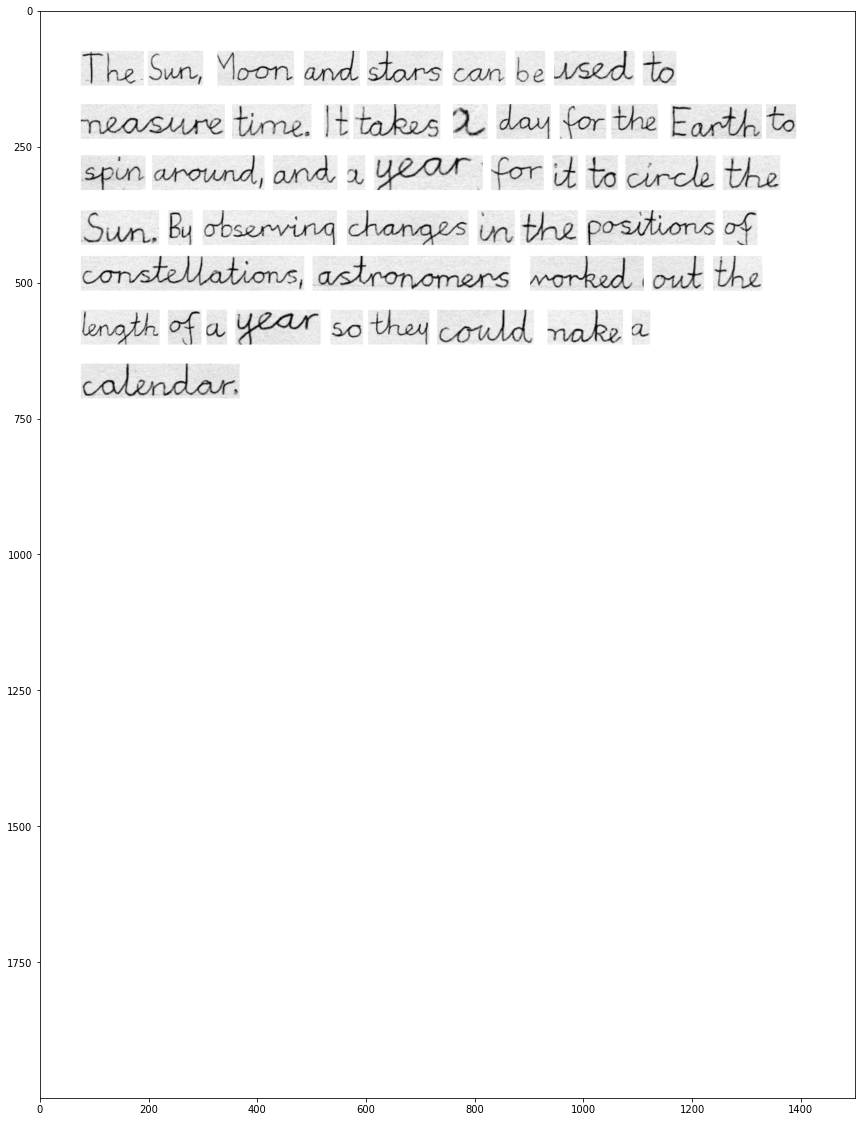

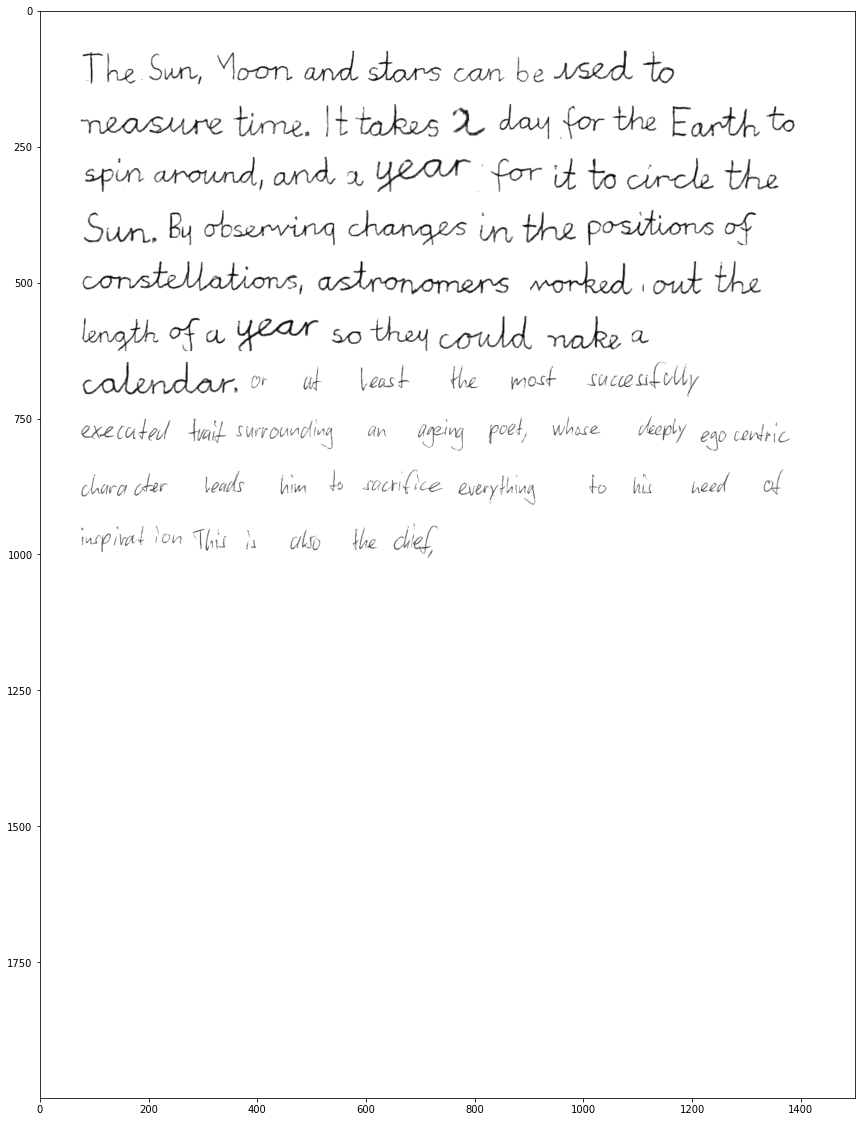

In [ ]:
from glob import glob
lst = glob('/content/sentences/*')
doc = initialize_document(document_path='/content/hand.jpeg', document_height=2000, document_width=1500, font_size=64)
i = 0
for path in lst:
    line = cv2.imread(path)
    imgs, labels, boxes, spaces = ocr_generated_line(line)
    doc.add_generated_sentence(imgs, labels, boxes, spaces)
    
    i += 1
    if i == 5:
        doc.plot_doc(True)
        break


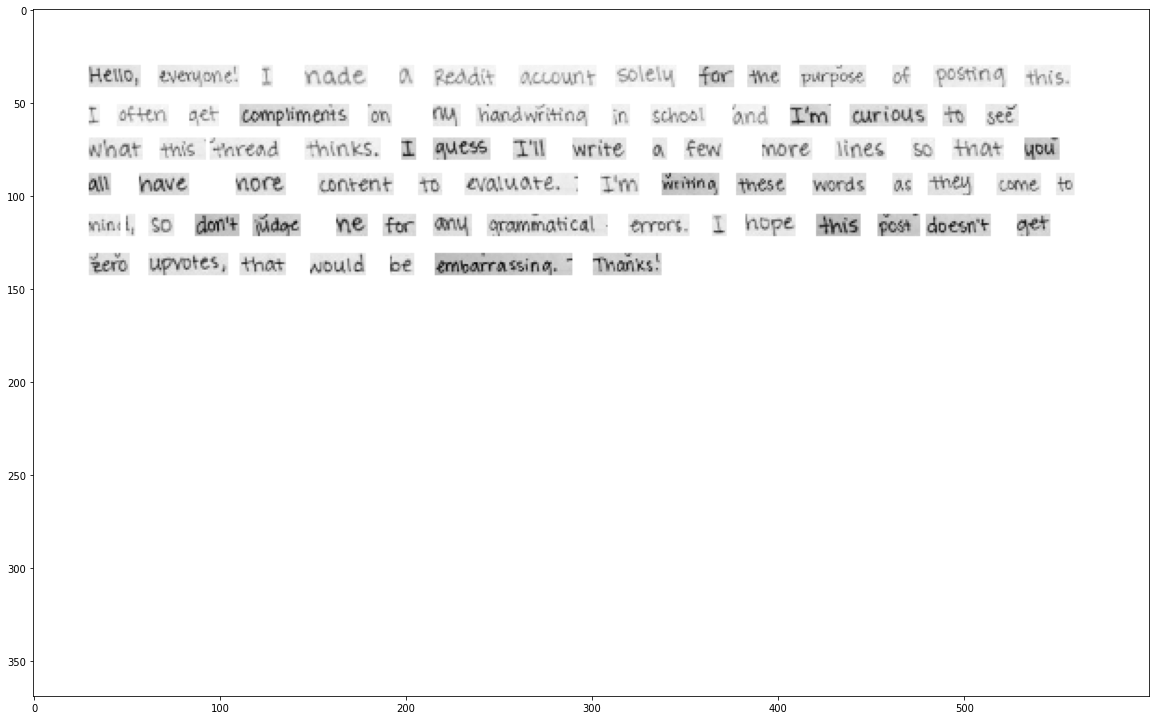

delete at 5


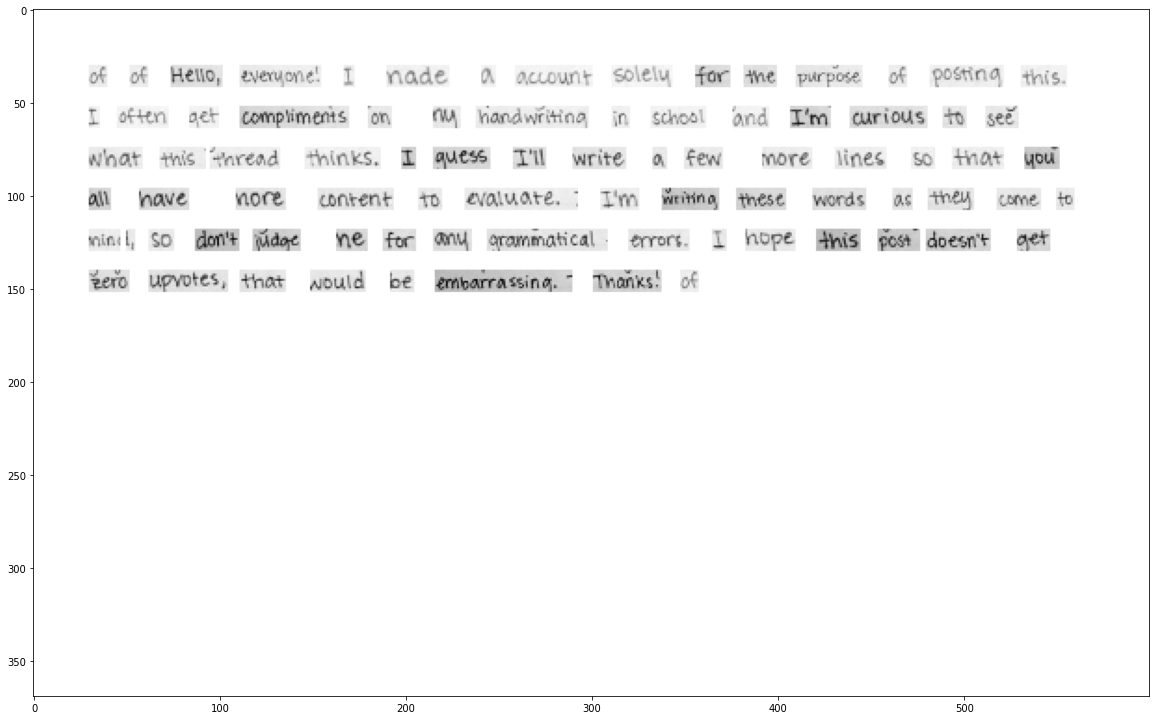

In [ ]:
doc1 = initialize_document(document_path='/content/hand2.jpg', original_dim=True)
doc1.delete_word(5)
doc1.set_new_lines(5)
word1 = doc1.get_word(10)
doc1.add_word(word1, 0)
doc1.add_word(word1, 0)
doc1.append_word(word1)
doc1.plot_doc()

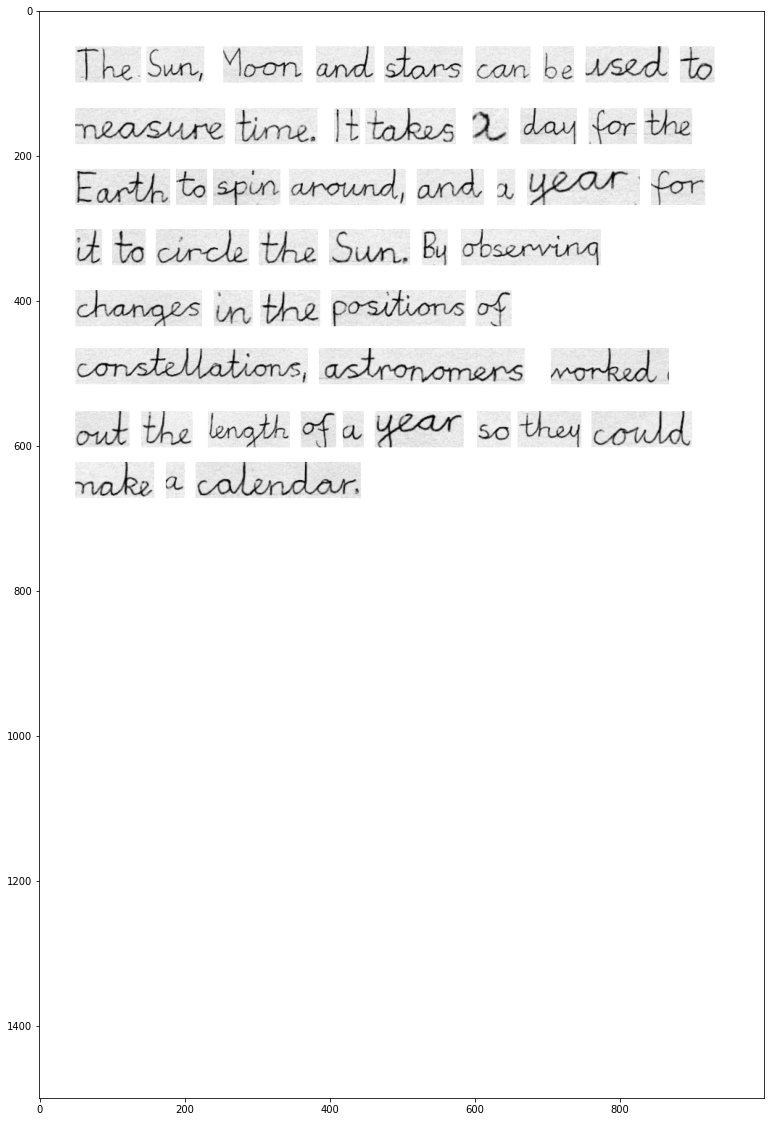

delete at 5


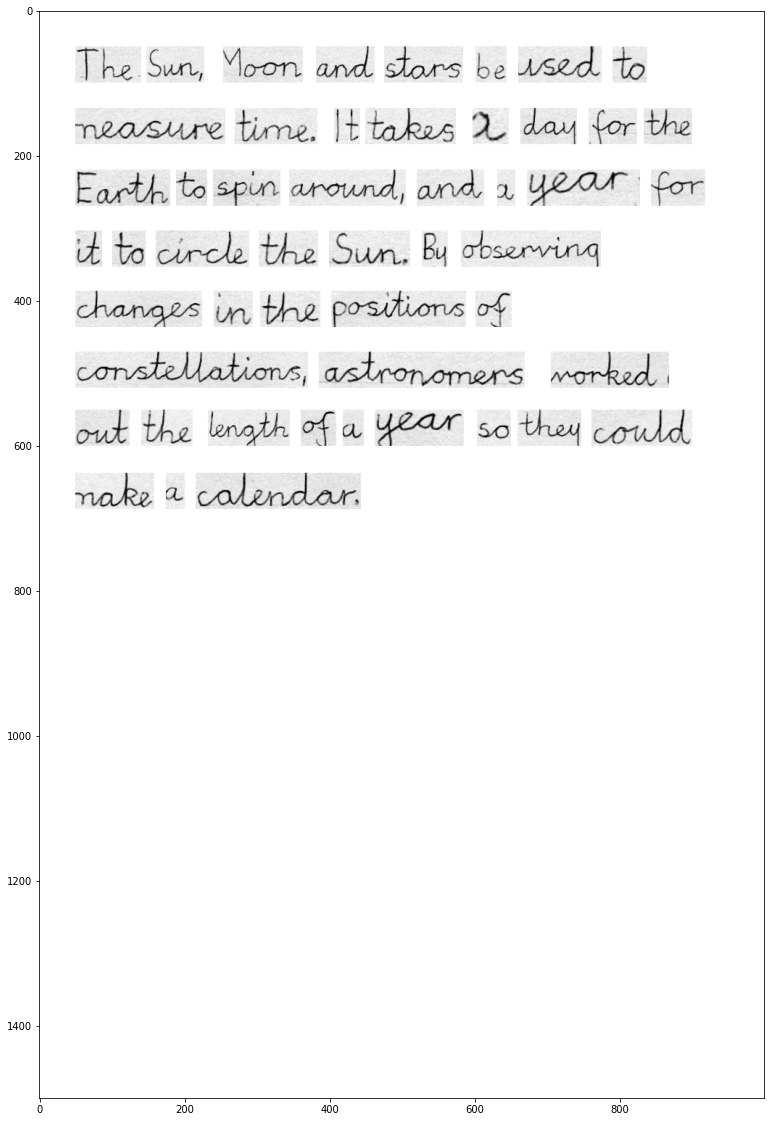

delete at 2


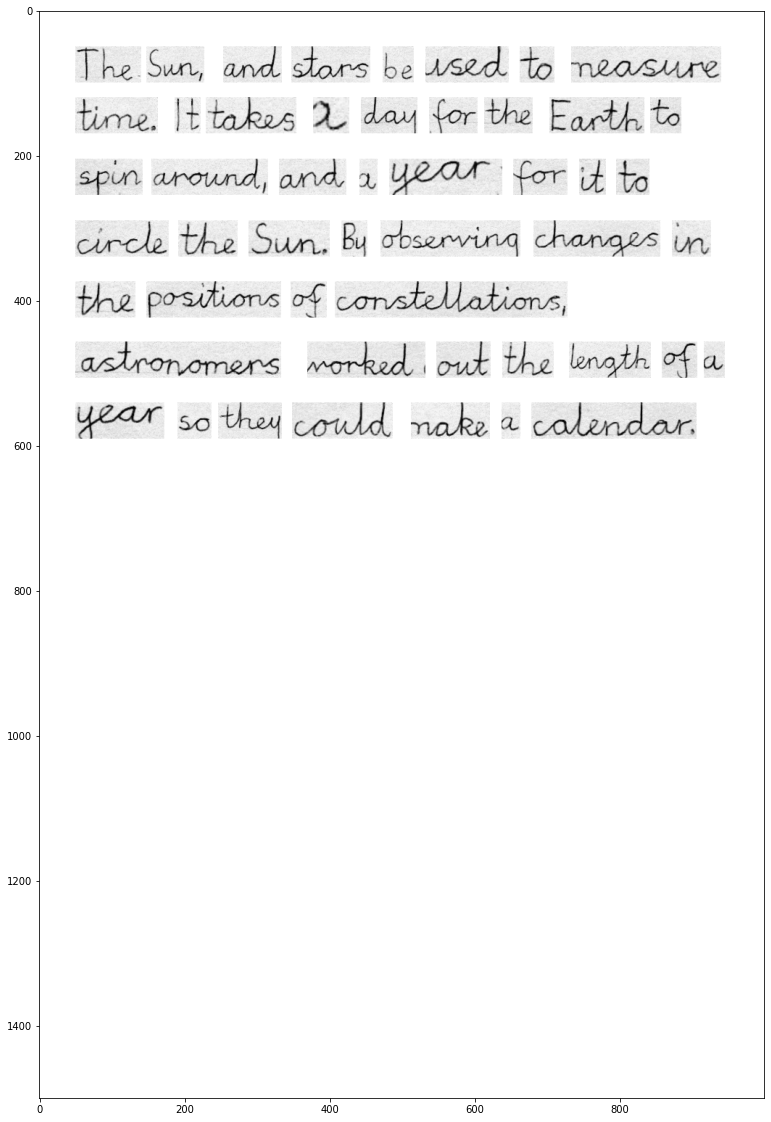

delete at 5


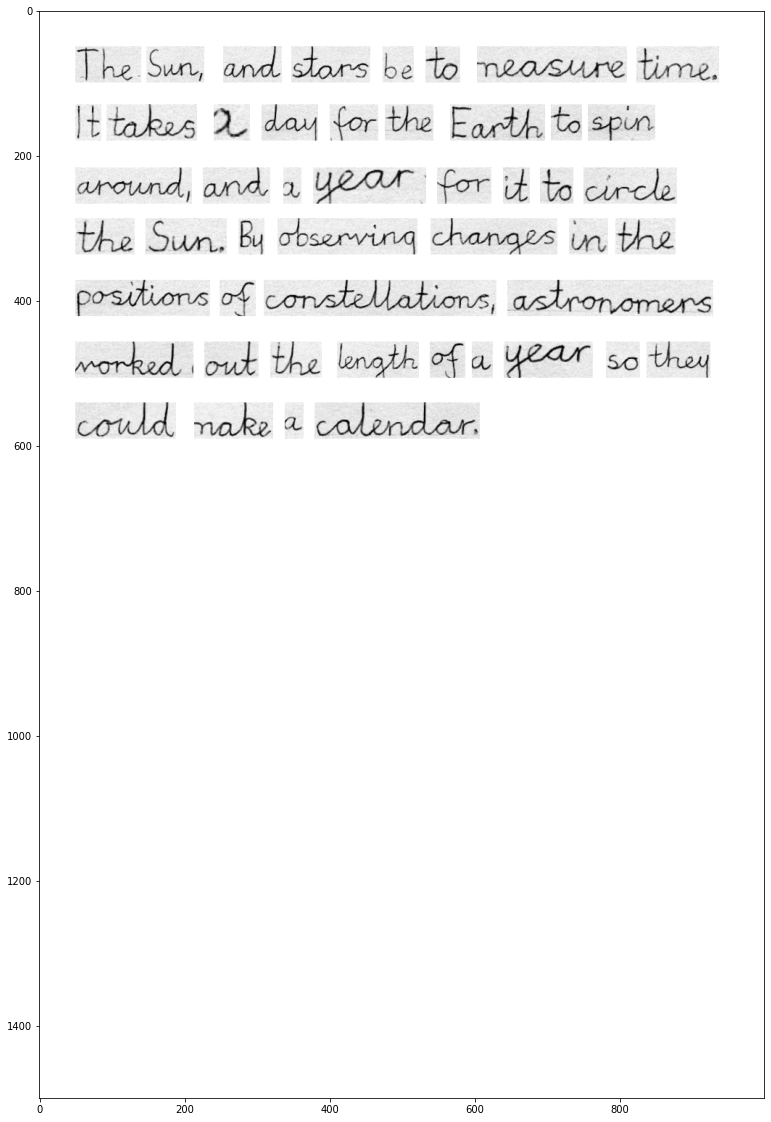

delete at 7


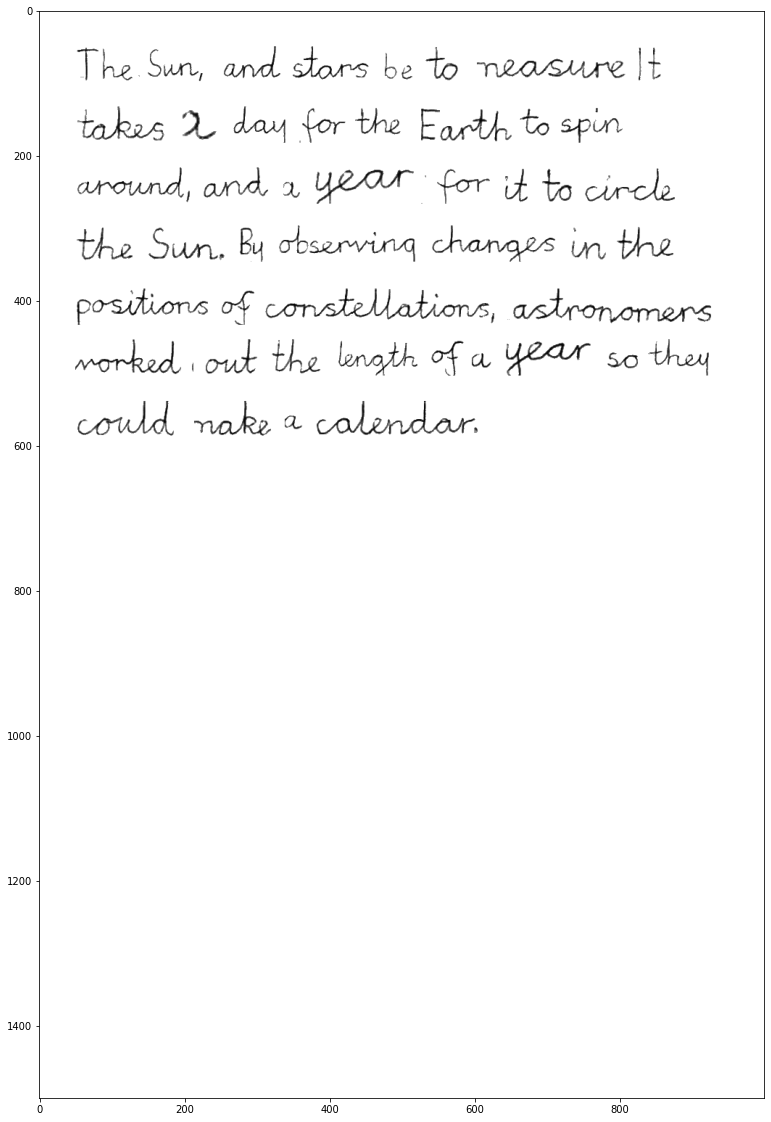

In [ ]:
doc3 = initialize_document(document_path='/content/hand.jpeg')
doc3.delete_word(5)
doc3.plot_doc()
doc3.delete_word(2)
doc3.plot_doc()
doc3.delete_word(5)
doc3.plot_doc()
doc3.delete_word(7)
doc3.plot_doc(True)